## ICCLIM C4I: Calculate the number of Summer Days


Example notebook that runs ICCLIM, which is pre-installed in the notebook.

The example calculates the number of summer days (SU indicator) for the dataset chosen by the user on C4I.

The data is read using xarray and a plot of the time series over a specific region is generated, as well as an average spatial map. Several output types examples are shown.

The dataset that is expected for this notebook are tasmax parameter (needed to calculate the SU indicator) for one specific climate model and experiment as well as one member. The time period should be continuous.

To keep this example fast to run, the following period is considered: 2015-01-01 to 2019-12-31, and plots are shown over European region.

### Preparation of the needed modules

In [1]:
import icclim

import sys
import glob
import os
import datetime
import cftime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

print("python: ",sys.version)
print("numpy: ", np.__version__)
print("xarray: ", xr.__version__)
print("pandas: ", pd.__version__)
print("icclim: ", icclim.__version__)
print("cftime: ", cftime.__version__)

python:  3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:39:48) 
[GCC 9.3.0]
numpy:  1.21.2
xarray:  0.19.0
pandas:  1.3.3
icclim:  4.2.20
cftime:  1.5.0


### Specification of the parameters and period of interest

In [ ]:
# studied period
dt1 = datetime.datetime(2015,1,1)
dt2 = datetime.datetime(2019,12,31)

out_f = 'su_icclim.nc'
filenames = glob.glob('./data/latest/tasmax_day*.nc')

icclim.indice(indice_name='SU', in_files=filenames, var_name='tasmax', slice_mode='JJA', time_range=[dt1, dt2], transfer_limit_Mbytes=200, out_file=out_f)


2021-10-22 07:32:25,790    ********************************************************************************************
2021-10-22 07:32:25,792    *                                                                                          *
2021-10-22 07:32:25,794    *          icclim                                                            V4.2.20       *
2021-10-22 07:32:25,795    *                                                                                          *
2021-10-22 07:32:25,795    *                                                                                          *
2021-10-22 07:32:25,796    *          Fri Oct 22 07:32:25 2021 GMT                                                    *
2021-10-22 07:32:25,797    *                                                                                          *
2021-10-22 07:32:25,798    *          BEGIN EXECUTION                                                                 *
2021-10-22 07:32:25,799    *            

### Plot preparation

In [4]:
with xr.open_dataset(out_f, decode_times=False) as ds:
    su_xr = ds
    ds['time'] = xr.decode_cf(ds).time

print(su_xr)

# Select a single x,y combination from the data
longitude = su_xr["SU"]["lon"].sel(lon=3.5, method='nearest')
latitude = su_xr["SU"]["lat"].sel(lat=44.2, method='nearest')

print("Long, Lat values:", longitude, latitude)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 256, lon: 512, nv: 2, time: 5)
Coordinates:
  * time       (time) datetime64[ns] 2015-07-16 2016-07-16 ... 2019-07-16
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    height     float64 ...
Dimensions without coordinates: bnds, nv
Data variables:
    time_bnds  (time, bnds) float64 ...
    lat_bnds   (lat, nv) float64 ...
    lon_bnds   (lon, nv) float64 ...
    SU         (time, lat, lon) float32 ...
Attributes:
    title:        ECA heat indice SU
    institution:  Climate impact portal (http://climate4impact.eu)
    source:       
    references:   ATBD of the ECA indices calculation (http://eca.knmi.nl/doc...
    comment:       
    history:      2019-09-27T21:04:23Z ; CMOR rewrote data to be consistent w...
    Conventions:  CF-1.6
Long, Lat values: <xarray.DataArray 'lon' ()>
array(3.515625)
Coordinates:
    lon      floa

### Subset and Plot

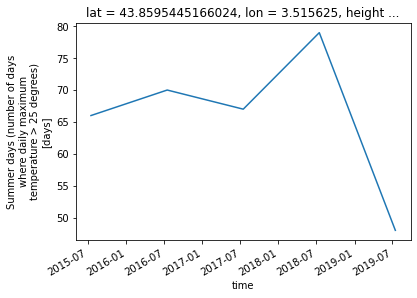

In [5]:
# Slice the data spatially using a single lat/lon point
one_point = su_xr["SU"].sel(lat=latitude, lon=longitude)

# Use xarray to create a quick time series plot
one_point.plot.line()
plt.show()

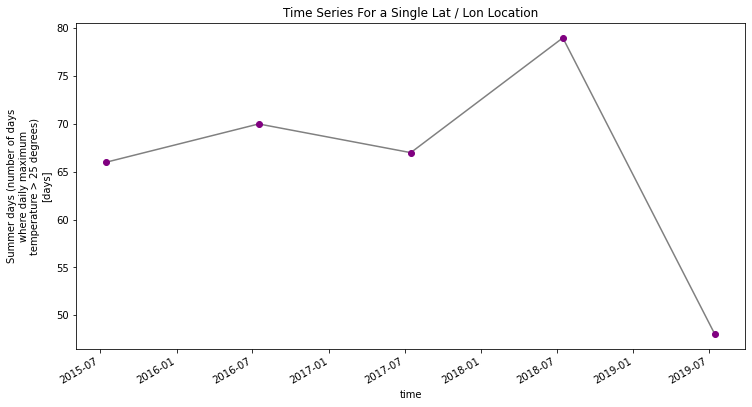

In [6]:
# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
one_point.plot.line(hue='lat',
                    marker="o",
                    ax=ax,
                    color="grey",
                    markerfacecolor="purple",
                    markeredgecolor="purple")
ax.set(title="Time Series For a Single Lat / Lon Location")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

In [7]:
# Convert to dataframe -- then this can easily be exported to a csv
one_point_df = one_point.to_dataframe()
# View just the first 5 rows of the data
one_point_df.head()

# Export data to .csv file
#one_point_df.to_csv("one-location.csv")

,lat,lon,height,SU
time,,,,
2015-07-16,43.859545,3.515625,2.0,66.0
2016-07-16,43.859545,3.515625,2.0,70.0
2017-07-16,43.859545,3.515625,2.0,67.0
2018-07-16,43.859545,3.515625,2.0,79.0
2019-07-16,43.859545,3.515625,2.0,48.0


In [8]:
# Time subsetting: this is just an example on how to do it
start_date = "2018-01-01"
end_date = "2019-12-31"

su = su_xr["SU"].sel(time=slice(start_date, end_date))

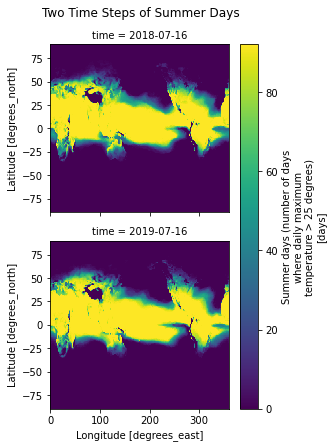

In [9]:
# Quickly plot the data using xarray.plot()
su.plot(x="lon",
        y="lat",
        col='time',
        col_wrap=1)

plt.suptitle("Two Time Steps of Summer Days", y=1.03)
plt.show()

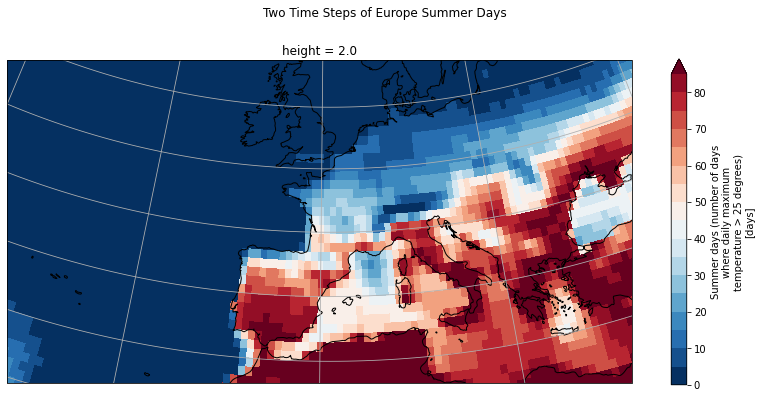

In [10]:
# Set spatial extent and centre
central_lat = 47.0
central_lon = 1.0
extent = [-30, 30, 30, 56]  # Western Europe

# Calculate time average
su_avg = su.mean(dim='time', keep_attrs=True)

# Set plot projection
map_proj = ccrs.AlbersEqualArea(central_longitude=central_lon,
                                central_latitude=central_lat)

# Define plot
f, ax = plt.subplots(figsize=(14, 6),
                     subplot_kw={'projection': map_proj})

# Plot data with proper colormap scale range
levels = np.arange(0, 90, 5)
p = su_avg.plot(levels=levels,
                cmap='RdBu_r',
                transform=ccrs.PlateCarree())

# Plot information
plt.suptitle("Two Time Steps of Europe Summer Days", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig('c4i_su_icclim.png')

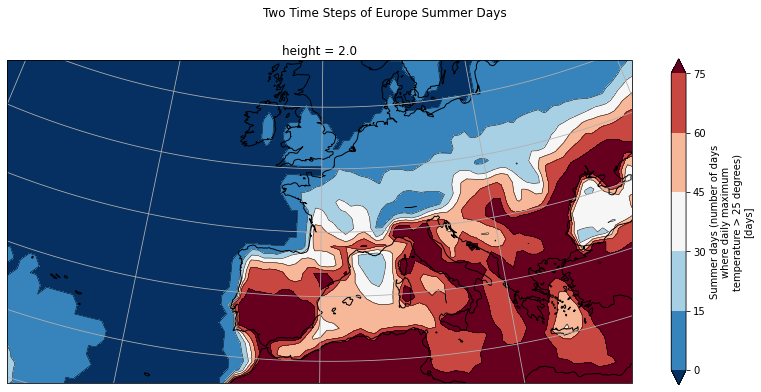

In [11]:
# Re-order longitude so that there is no blank line at 0 deg because 0 deg is within our spatial selection
su_avg.coords['lon'] = (su_avg.coords['lon'] + 180) % 360 - 180
su_avg = su_avg.sortby(su_avg.lon)

# Define plot
f, ax = plt.subplots(figsize=(14, 6),
                     subplot_kw={'projection': map_proj})

# Define colorscale
levels = np.arange(0, 90, 15)

# Contours lines
p = su_avg.plot.contour(levels=levels,
                         colors='k',
                         linewidths=0.5,
                         transform=ccrs.PlateCarree())

# Contour filled colors
p = su_avg.plot.contourf(levels=levels,
                          cmap='RdBu_r',
                          extend='both',
                          transform=ccrs.PlateCarree())

# Plot information
plt.suptitle("Two Time Steps of Europe Summer Days", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig('c4i_su_contours_icclim.png')